### Test Model on FORBOW Dataset

In [1]:
import pandas as pd
import plotnine as p9
import warnings
import sys

from datetime import datetime
from plotnine import *
from pyprojroot import here
from scipy import stats

import statsmodels.api as sm

sys.path.insert(0, f"{here()}/src")
from prep_columns import read_dataframe
from test import test
from plots import scatter_bag_age

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.reset_option("mode.chained_assignment")

datem = datetime.today().strftime("%Y-%m-%d")

### Clean FORBOW Data

In [2]:
frb_df_raw = pd.read_csv(f'{here()}/data/raw/frb/2025-02-05_frb_mri_pheno.csv', sep=",")

/var/folders/7w/4mwg2xbx4j9645_p5tvccmph0000gn/T/ipykernel_4820/4124206342.py:1: DtypeWarning: Columns (1,2,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,13

### Exclude as per MRIQC, plus those with NA values

In [3]:
frb_df_raw.recommendation.value_counts()

recommendation
Include    715
Exclude     24
Name: count, dtype: int64

In [4]:
frb_df = frb_df_raw[frb_df_raw['recommendation'] == 'Include']

In [5]:
frb_df.shape, frb_df_raw.shape

((715, 2875), (755, 2875))

In [6]:
frb_df["group"] = frb_df["group"].replace([0.0, 1.0, 2.0, 3.0], ["Ctrls", "FHR (SMI)", "FHR (SMI)", "FHR (SMI)"])
frb_df = frb_df[frb_df['scan_age'].notna()]

/var/folders/7w/4mwg2xbx4j9645_p5tvccmph0000gn/T/ipykernel_4820/3845419388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
frb_df[["scan_id", "scan_time"]] = frb_df["scan_id"].str.split(pat="_", n=1, expand=True)
frb_df = frb_df[frb_df['group'] != "FHR (Schz)"]

In [8]:
pheno = frb_df[["scan_id", "scan_time", "forbow_id", "iid", "fid", "mother_id", "father_id",\
                "assessment_date", "dob", "age", "sex", "group", "clsmi", "polye", 'cistot', "yetitot", \
                "cladhd", "ses", "iq", "clmdd", "clbpd", "clschz", "clmood", "clpsychosis", "clanx", "ccpsychosis", 'antpsych', 'cantpsych', \
                "ccanx", "parentsmi", "ses", "fsiq", "bullying", "age", "scan_age"]]

In [9]:
pheno.tail(3)

,scan_id,scan_time,forbow_id,iid,fid,mother_id,father_id,assessment_date,dob,age,sex,group,clsmi,polye,cistot,yetitot,cladhd,ses,iq,clmdd,clbpd,clschz,clmood,clpsychosis,clanx,ccpsychosis,antpsych,cantpsych,ccanx,parentsmi,ses,fsiq,bullying,age,scan_age
751,230,E,8000294559,559.0,294.0,8000294M1,8000294F1,2024-04-17,2003-02-24,21.139999,Female,FHR (SMI),0.0,0.2,NaN,33,1.0,3.0,99.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,21.139999,21.182752
752,179,I,8000227419,419.0,227.0,8000227M1,8000227F1,2024-05-03,2009-06-14,14.890000,Male,Ctrls,0.0,0.4,15.23077,42,1.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,14.890000,14.918549
753,278,C,8000115203,203.0,115.0,8000115M1,8000115F1,2024-05-08,2013-01-01,11.350000,Male,FHR (SMI),0.0,0.5,0.00000,36,0.0,2.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,0.0,11.350000,11.405886


In [10]:
frb_df.shape, pheno.shape

((714, 2875), (714, 35))

### Test and age correct FORBOW data

In [11]:
mri = read_dataframe(frb_df)

(714, 190)


In [12]:
mri.scan_age.describe()

count    714.000000
mean      15.126902
std        3.981255
min        8.733744
25%       11.818617
50%       14.568104
75%       17.735797
max       26.548939
Name: scan_age, dtype: float64

/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 12 rows containing non-finite values.
/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 12 rows containing non-finite values.
/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


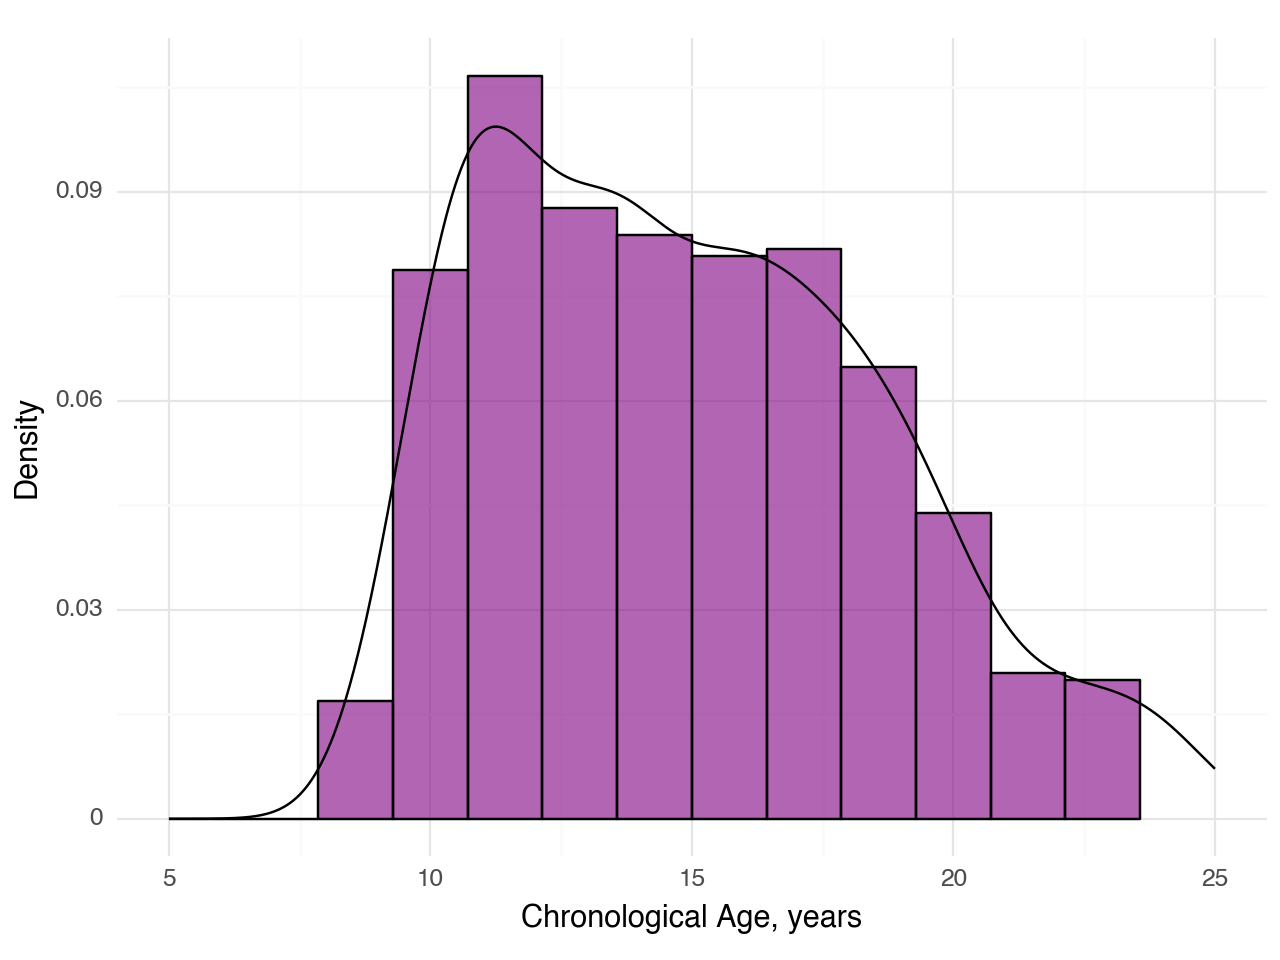

In [13]:
plot = (
    ggplot(pheno, aes(x='scan_age')) +
    geom_histogram(aes(y='..density..'), fill=f'purple', bins=15, alpha=0.6, color='black') + 
    geom_density(color='black', alpha=0.5) + 
    xlab('Chronological Age, years') +
    ylab('Density') + 
    theme_minimal() +
    xlim(5, 25))

print(plot)

#plot.save(f"{here()}/figures/bhrc3_age_distribution.png", dpi=800)

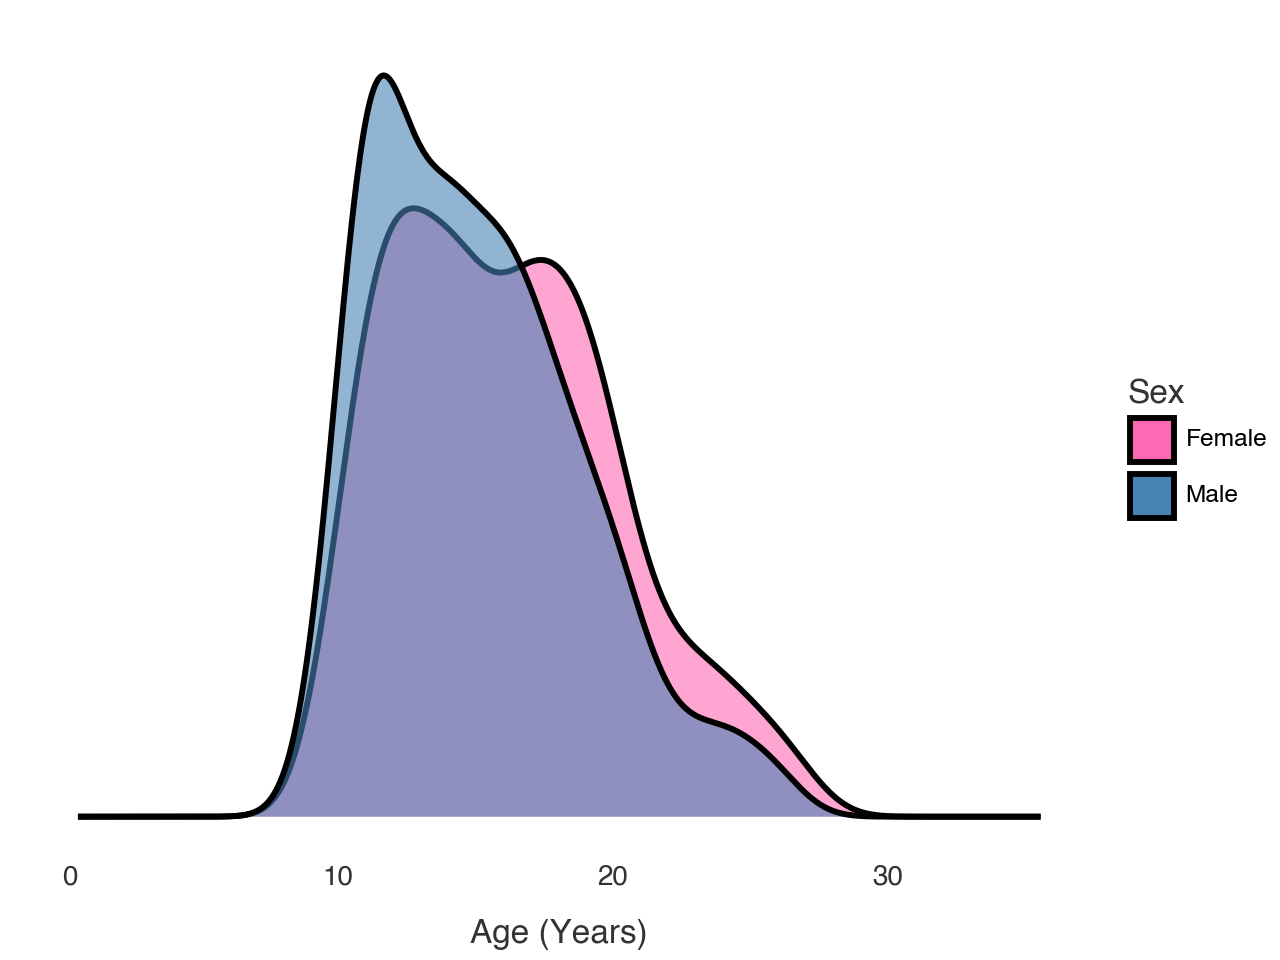

In [14]:
ggplot = (
    p9.ggplot(pheno, p9.aes(x="scan_age", y="..density..", fill="sex"))
    + p9.geom_density(alpha=0.6, size=1.2)  # Increased line size for better visibility
    + p9.scale_fill_manual(values=["#FF69B4", "#4682B4"]) #["#66CCCC", "#FF99CC"])  # Pastel colors with good contrast
    + p9.theme_void()
    + p9.theme(
        axis_text_x=p9.element_text(angle=0, hjust=1, margin={'t': 5}, size=10, color="#333333"),
        axis_title_x=p9.element_text(vjust=-0.5, size=12, color="#333333"),
        axis_title_y=p9.element_blank(),  # Remove y-axis label
        legend_title=p9.element_text(vjust=0.5, size=12, color="#333333"),
        legend_position="right",
        strip_text_y=p9.element_text(angle=0, ha="right", va="center", size=10, color="#333333"),
        panel_background=p9.element_rect(fill="#FFFFFF"),  # White panel background
        plot_background=p9.element_rect(fill="#FFFFFF"),  # White plot background
        panel_grid_major=p9.element_blank(),  # Remove major grid lines
        panel_grid_minor=p9.element_blank()  # Remove minor grid lines
    )
    + p9.labs(x="Age (Years)", y="", fill="Sex")  # Set y-axis label to empty string
    + p9.xlim(0, 35)  # Set x-axis limits to 5-25
    + p9.guides(fill=p9.guide_legend(override_aes={"alpha": 1}))  # Solid legend colors
)
print(ggplot)

#ggplot.save("../figures/frb_distribution.png", dpi=800)


In [15]:
pheno_descriptives = pheno.drop_duplicates(subset=['scan_id'])
pheno_descriptives.shape

(283, 35)

In [17]:
pheno_descriptives.sex.value_counts()

sex
Male      144
Female    139
Name: count, dtype: int64

In [18]:
pheno.shape, mri.shape

((714, 35), (714, 190))

In [19]:
pheno_ = pheno[["scan_id", "scan_time", "scan_age", "sex"]]

In [20]:
mri_ = pd.concat([mri, pheno_], axis=1) #, on=["scan_id", "scan_age"], how="left")

In [21]:
mri_.shape, pheno_.shape, mri.shape

((714, 194), (714, 4), (714, 190))

In [22]:
mri = mri_.loc[:,~mri_.columns.duplicated()]

In [23]:
male = mri[mri['sex'] == "Male"]
female = mri[mri['sex'] == "Female"]

In [24]:
male.shape, female.shape, mri.sex.value_counts()

((333, 191),
 (381, 191),
 sex
 Female    381
 Male      333
 Name: count, dtype: int64)

In [25]:
male =male.drop(['sex', 'scan_time'], axis=1)
female = female.drop(['sex', 'scan_time'] , axis=1)

In [26]:
male.sample()

,fs_3rdvent_vol,fs_4thvent_vol,fs_brainseg_vol,fs_brainseg_vol_no_vent,fs_brainseg_vol_no_vent_surf,fs_brainsegvol_etiv_ratio,fs_brainstem_vol,fs_cc_anterior_vol,fs_cc_central_vol,fs_cc_midanterior_vol,fs_cc_midposterior_vol,fs_cc_posterior_vol,fs_csf_vol,fs_intercranial_vol,fs_l_accumbensarea_vol,fs_l_amygdala_vol,fs_l_bankssts_area,fs_l_bankssts_grayvol,fs_l_caudalanteriorcingulate_area,fs_l_caudalanteriorcingulate_grayvol,fs_l_caudalmiddlefrontal_area,fs_l_caudalmiddlefrontal_grayvol,fs_l_caudate_vol,fs_l_cerebellum_cort_vol,fs_l_cerebellum_wm_vol,fs_l_choroidplexus_vol,fs_l_cuneus_area,fs_l_cuneus_grayvol,fs_l_entorhinal_area,fs_l_entorhinal_grayvol,fs_l_frontalpole_area,fs_l_frontalpole_grayvol,fs_l_fusiform_area,fs_l_fusiform_grayvol,fs_l_hippo_vol,fs_l_inferiorparietal_area,fs_l_inferiorparietal_grayvol,fs_l_inferiortemporal_area,fs_l_inferiortemporal_grayvol,fs_l_inflatvent_vol,fs_l_insula_area,fs_l_insula_grayvol,fs_l_isthmuscingulate_area,fs_l_isthmuscingulate_grayvol,fs_l_lateraloccipital_area,fs_l_lateraloccipital_grayvol,fs_l_lateralorbitofrontal_area,fs_l_lateralorbitofrontal_grayvol,fs_l_latvent_vol,fs_l_lingual_area,fs_l_lingual_grayvol,fs_l_medialorbitofrontal_area,fs_l_medialorbitofrontal_grayvol,fs_l_middletemporal_area,fs_l_middletemporal_grayvol,fs_l_pallidum_vol,fs_l_paracentral_area,fs_l_paracentral_grayvol,fs_l_parahippocampal_area,fs_l_parahippocampal_grayvol,fs_l_parsopercularis_area,fs_l_parsopercularis_grayvol,fs_l_parsorbitalis_area,fs_l_parsorbitalis_grayvol,fs_l_parstriangularis_area,fs_l_parstriangularis_grayvol,fs_l_pericalcarine_area,fs_l_pericalcarine_grayvol,fs_l_postcentral_area,fs_l_postcentral_grayvol,fs_l_posteriorcingulate_area,fs_l_posteriorcingulate_grayvol,fs_l_precentral_area,fs_l_precentral_grayvol,fs_l_precuneus_area,fs_l_precuneus_grayvol,fs_l_putamen_vol,fs_l_rostralanteriorcingulate_area,fs_l_rostralanteriorcingulate_grayvol,fs_l_rostralmiddlefrontal_area,fs_l_rostralmiddlefrontal_grayvol,fs_l_superiorfrontal_area,fs_l_superiorfrontal_grayvol,fs_l_superiorparietal_area,fs_l_superiorparietal_grayvol,fs_l_superiortemporal_area,fs_l_superiortemporal_grayvol,fs_l_supramarginal_area,fs_l_supramarginal_grayvol,fs_l_temporalpole_area,fs_l_temporalpole_grayvol,fs_l_thalamusproper_vol,fs_l_transversetemporal_area,fs_l_transversetemporal_grayvol,fs_l_ventdc_vol,fs_l_vessel_vol,fs_lcort_gm_vol,fs_mask_vol,fs_maskvol_etiv_ratio,fs_opticchiasm_vol,fs_r_accumbensarea_vol,fs_r_amygdala_vol,fs_r_bankssts_area,fs_r_bankssts_grayvol,fs_r_caudalanteriorcingulate_area,fs_r_caudalanteriorcingulate_grayvol,fs_r_caudalmiddlefrontal_area,fs_r_caudalmiddlefrontal_grayvol,fs_r_caudate_vol,fs_r_cerebellum_wm_vol,fs_r_choroidplexus_vol,fs_r_cuneus_area,fs_r_cuneus_grayvol,fs_r_entorhinal_area,fs_r_entorhinal_grayvol,fs_r_frontalpole_area,fs_r_frontalpole_grayvol,fs_r_fusiform_area,fs_r_fusiform_grayvol,fs_r_hippo_vol,fs_r_inferiorparietal_area,fs_r_inferiorparietal_grayvol,fs_r_inferiortemporal_area,fs_r_inferiortemporal_grayvol,fs_r_inflatvent_vol,fs_r_insula_area,fs_r_insula_grayvol,fs_r_isthmuscingulate_area,fs_r_isthmuscingulate_grayvol,fs_r_lateraloccipital_area,fs_r_lateraloccipital_grayvol,fs_r_lateralorbitofrontal_area,fs_r_lateralorbitofrontal_grayvol,fs_r_latvent_vol,fs_r_lingual_area,fs_r_lingual_grayvol,fs_r_medialorbitofrontal_area,fs_r_medialorbitofrontal_grayvol,fs_r_middletemporal_area,fs_r_middletemporal_grayvol,fs_r_pallidum_vol,fs_r_paracentral_area,fs_r_paracentral_grayvol,fs_r_parahippocampal_area,fs_r_parahippocampal_grayvol,fs_r_parsopercularis_area,fs_r_parsopercularis_grayvol,fs_r_parsorbitalis_area,fs_r_parsorbitalis_grayvol,fs_r_parstriangularis_area,fs_r_parstriangularis_grayvol,fs_r_pericalcarine_area,fs_r_pericalcarine_grayvol,fs_r_postcentral_area,fs_r_postcentral_grayvol,fs_r_posteriorcingulate_area,fs_r_posteriorcingulate_grayvol,fs_r_precentral_area,fs_r_precentral_grayvol,fs_r_precuneus_area,fs_r_precuneus_grayvol,fs_r_putamen_vol,fs_r_rostralanteriorcingulate_grayvol,fs

In [27]:
mri.drop(columns=['sex', 'scan_time'], inplace=True)

/var/folders/7w/4mwg2xbx4j9645_p5tvccmph0000gn/T/ipykernel_4820/2580462265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Test with XGBoost

In [28]:
df_result = test(mri, sex='all')

(714, 187)
MAE: 2.2109080036599384
Adjusted MAE: 2.2659876084064723
Correlation (Age * brain_age): 0.7145190918022584
Correlation (Age * adjusted_brain_age): 0.7145190881182564
Correlation (Age * brain_age_gap): -0.5291799473786917
Correlation (Age * adjusted_brain_age_gap): -0.46211266754557584


/Users/waigwa/Documents/neptune/src/test.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/waigwa/Documents/neptune/src/test.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Age Bias Correction

In [29]:
df_result.chronological_age.describe()

count    714.000000
mean      15.126902
std        3.981255
min        8.733744
25%       11.818617
50%       14.568104
75%       17.735797
max       26.548939
Name: chronological_age, dtype: float64

In [30]:
df_result['cage'] = df_result['chronological_age'] - 15

X = df_result["cage"] 
y = df_result["adjusted_brain_age_gap"] 
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     adjusted_brain_age_gap   R-squared:                       0.214
Model:                                OLS   Adj. R-squared:                  0.212
Method:                     Least Squares   F-statistic:                     193.3
Date:                    Thu, 06 Feb 2025   Prob (F-statistic):           4.65e-39
Time:                            16:33:44   Log-Likelihood:                -1689.7
No. Observations:                     714   AIC:                             3383.
Df Residuals:                         712   BIC:                             3393.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3039      0.097     -3.142      0.002      -0.494      -0.114
cage          -0.3378      0.024    -13.904      0.000      -0.386      -0.290
==============================================================================
Omnibus:                       69.769   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.771
Skew:                           0.672   Prob(JB):                     5.36e-25
Kurtosis:                       4.397   Cond. No.                         3.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model.params

const   -0.303887
cage    -0.337845
dtype: float64

In [32]:
df_result['corrected_brain_age_gap'] = df_result["adjusted_brain_age_gap"] - predictions

In [33]:
df_result["corrected_brain_age_gap"].corr(df_result["adjusted_brain_age_gap"])

0.8868212235247372

In [34]:
df_result["corrected_brain_age_gap"].corr(df_result["chronological_age"])

1.6679521616970823e-16

In [35]:
df_result['bag_z_scored'] = stats.zscore(df_result['corrected_brain_age_gap'])

min age: 8.733744010951403, median: 14.568104038329913, max: 26.548939082819988


/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


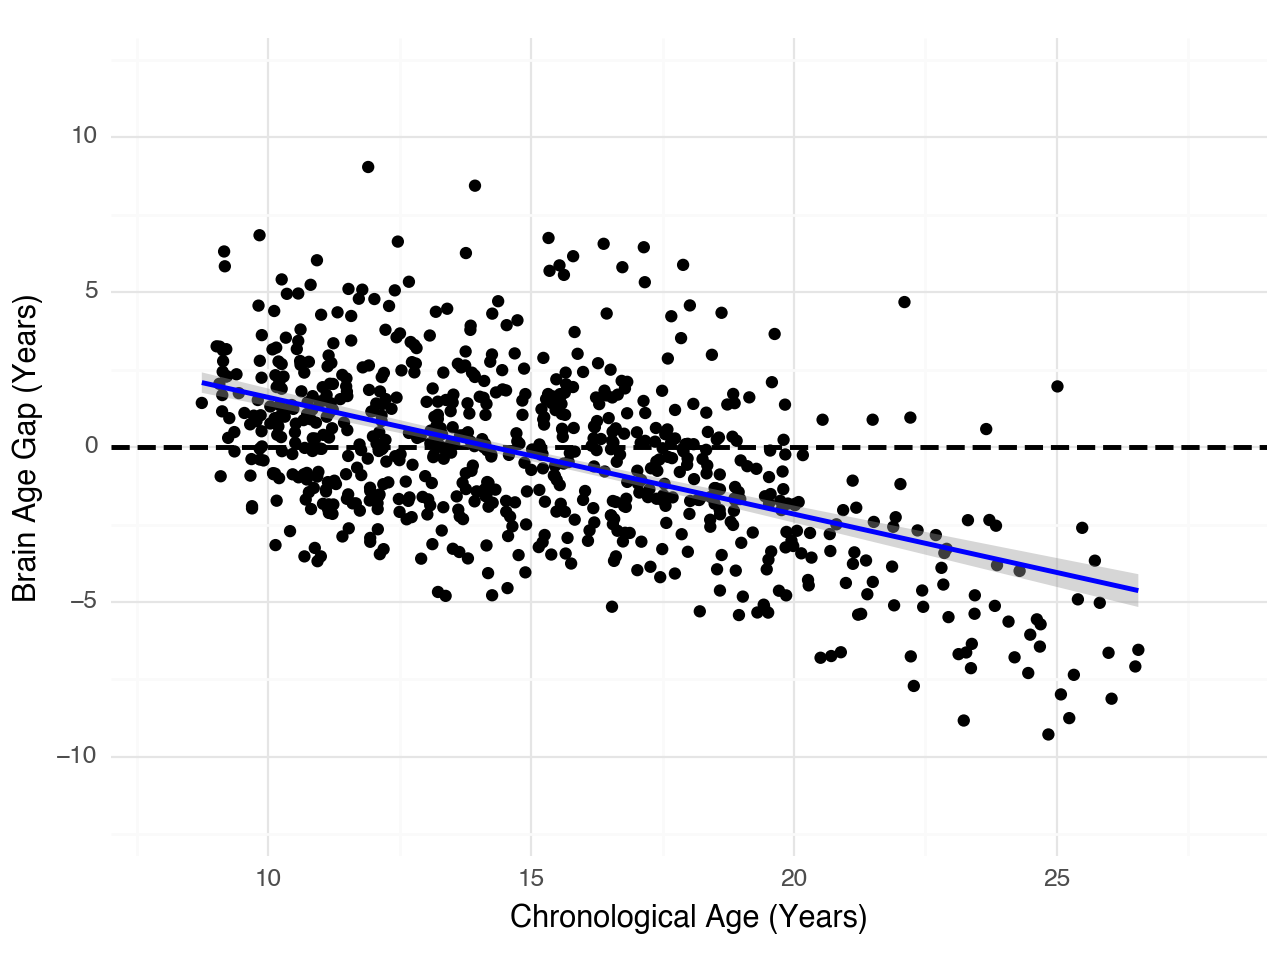

/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/waigwa/Documents/neptune/figures/frb_bag_age_plot.png
/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


In [36]:
scatter_bag_age(df_result, "frb")

In [37]:
df_result.shape, pheno.shape

((714, 8), (714, 35))

In [38]:
df = pd.concat([pheno, df_result], axis=1)

#### A little data cleaning

In [39]:
df.rename(columns={"cladhd": "adhd", "clmdd": "depression", "clbpd": "bpd", "clpsychosis": "psychoticdis", "cantpsych": "psychosis", 
                "cistot": "impairment", \
                "clschz": "schz", "clanx": "anxiety", "yetitot": "antecedents", "polye": "adversity", "clsmi": "smi", "clmood": "mood"}, inplace=True)

In [40]:
diag = {0.0: 'No', 1.0: 'Yes'}

#df['adversity'] = df['adversity'].map(diag)
df['psychoticdis'] = df['psychoticdis'].map(diag)
df['psychosis'] = df['psychosis'].map(diag)
df['bullying'] = df['bullying'].map(diag)
df['bpd'] = df['bpd'].map(diag)
df['mood'] = df['mood'].map(diag)
df['adhd'] = df['adhd'].map(diag)
df['schz'] = df['schz'].map(diag)
df['anxiety'] = df['anxiety'].map(diag)
df['depression'] = df['depression'].map(diag)
df['smi'] = df['smi'].map(diag)

df['antecedents'] = df['antecedents'].apply(lambda x: 'Yes' if x >= 8 else 'No')
df['impairment'] = df['impairment'].apply(lambda x: 'Yes' if x >= 15 else 'No')

/Users/waigwa/Documents/neptune/neptune/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 12 rows containing non-finite values.


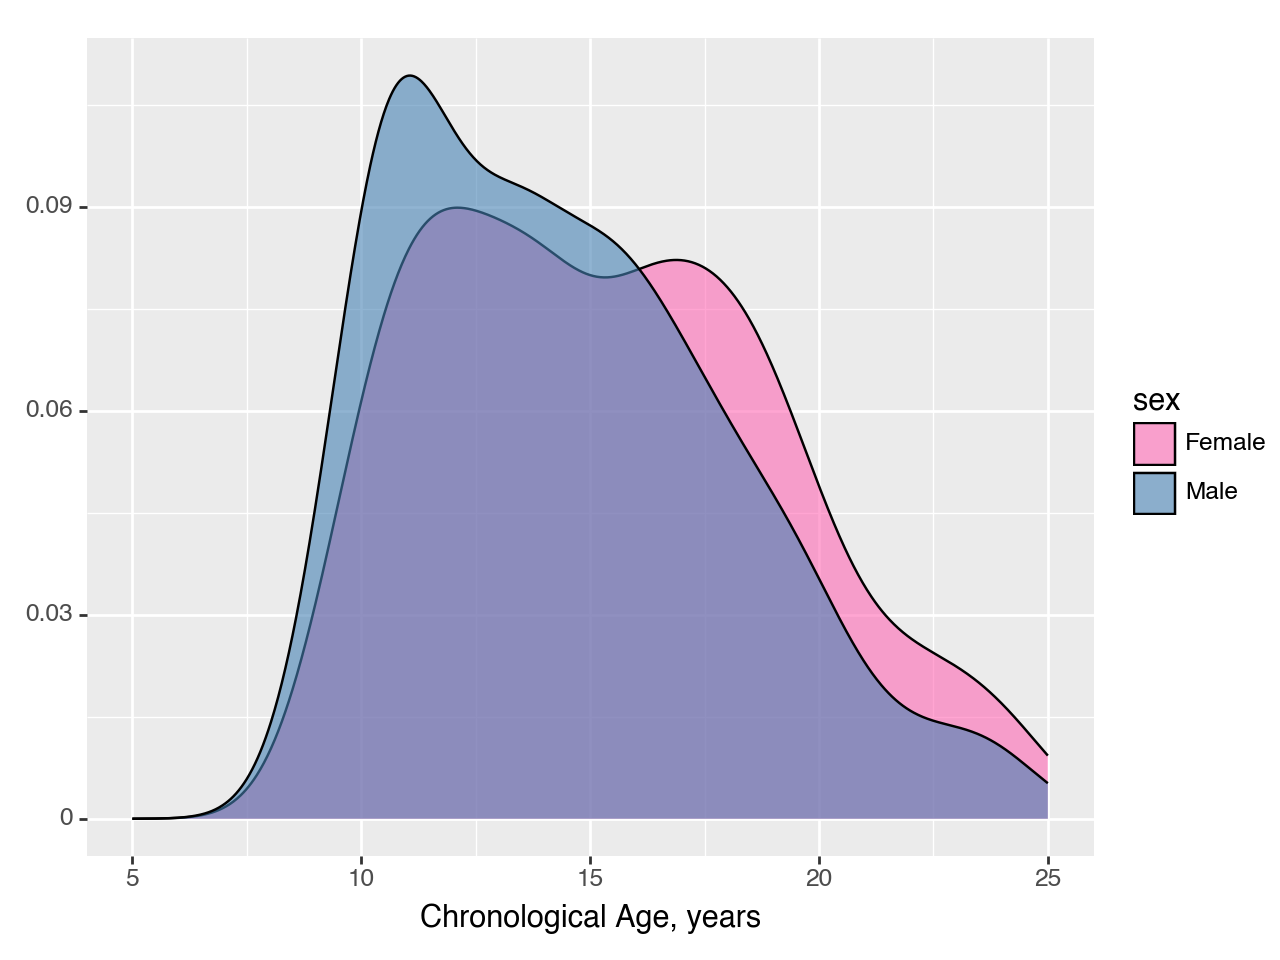

In [41]:
ggplot = (
    p9.ggplot(df, p9.aes(x="chronological_age", y="..density..", fill="sex"))
    + p9.geom_density(p9.aes(group="sex"), alpha=0.6)
    + p9.scale_fill_manual(values=["#FF69B4", "#4682B4"])
    + p9.labs(x="Chronological Age, years", y="", fill="sex")  
    + p9.xlim(5, 25)
)
print(ggplot)

In [43]:
df.to_csv(f"{here()}/data/processed/{datem}_forbow_brain_age_results.csv", index=False)